<a href="https://colab.research.google.com/github/sherlockieee/cs152/blob/main/CS152_Assignment2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1>CS152 Assignment 2: The 8-puzzle</h1>

Before you turn in this assignment, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then run the test cells for each of the questions you have answered.  Note that a grade of 3 for the A* implementation requires all tests in the "Basic Functionality" section to be passed.  The test cells pass if they execute with no errors (i.e. all the assertions are passed).

Make sure you fill in any place that says `YOUR CODE HERE`.  Be sure to remove the `raise NotImplementedError()` statements as you implement your code - these are simply there as a reminder if you forget to add code where it's needed.

---

<h1>
Question 1    
</h1>
Define your <code>PuzzleNode</code> class below.  Ensure that you include all attributes that you need to implement an A* search.  If you wish, you can even include member functions, such as a function to generate successor states.  Alternatively, you can code up this functionality later in the <code>solvePuzzle</code> function.

In [14]:
# Import any packages you need here
# Also define any variables as needed
from copy import deepcopy

#Now, define the class PuzzleNode:
class PuzzleNode:
    '''
    Provides a structure for performing A* search for the n^2-1 puzzle
    
    Parameters
    ----------
    state : list[list[int]]
        The state of the n x n puzzle
    fval: int
        The estimated cheapest cost of traversing from the node to the solution
    gval: int
        The cost to reach this node
    parent: PuzzleNode/ None
        The parent PuzzleNode that is one step before this step

    Attributes
    ----------
    state : list[list[int]]
        The state of the n x n puzzle
    fval: int
        The estimated cheapest cost of traversing from the node to the solution
    gval: int
        The cost to reach this node
    parent: PuzzleNode/ None
        The parent PuzzleNode that is one step before this step
    pruned: boolean
        Whether we have visited the node
    '''
    
    # YOUR CODE HERE
    def __init__(self, state, fval, gval, parent=None):
        self.state = state
        self.n = len(state)
        self.fval = fval
        self.gval = gval
        self.parent = parent
        self.pruned = False
    
    def __str__(self):
        string = []
        for row in self.state:
            string.append(str([str(a) if a != 0 else "X" for a in row]))
            string.append("\n")
        return "".join(string)

    def __lt__(self, other):
        return self.fval < other.fval

    def is_validated(self):
        """
        Helper function to validate whether our board is of the 
        appropriate size and dimension given the board state

        Parameters
        ----------
        None

        Returns
        ----------
        boolean
            whether the board is an appropriate size and dimension
        """
        found_set = set()
        for i in range(self.n):
            if len(self.state[i]) != self.n:
                #check if dimension is incorrect
                return False
            for j in range(self.n):
                #Check for out of range value
                if self.state[i][j] >= self.n ** 2 or self.state[i][j] < 0:
                    return False
                #Check for duplicates
                if self.state[i][j] in found_set:
                    return False
                found_set.add(self.state[i][j])
        return len(found_set) == self.n ** 2

    def create_goal_state(self):
        """
        Helper function to create the goal state of the board

        Parameters
        ----------
        None

        Returns
        ----------
        list[list[int]]
            The goal state of the n x n puzzle
        """
        if not self.is_validated():
            return InputError
        ans = []
        for i in range(self.n ** 2):
            if i % self.n == 0:
                ans.append([])
            ans[-1].append(i)
        return ans

    def find_next_states(self):
        """
        Helper function to find all the next states given a state

        Parameters
        ----------
        None

        Returns
        ----------
        list[list[list[int]]]
            All the possible next states for the current state
        """
        x, y = None, None

        #find the 0 value, which is the value we can move
        for i in range(self.n):
            if x and y:
                break
            for j in range(self.n):
                if self.state[i][j] == 0:
                    x, y = i, j
                    break
        
        new_states = []

        #we can move the 0 position 4 ways
        moves = ((1,0),(0,1),(-1,0),(0,-1))

        for move_x, move_y in moves:
            #find the other value to swap with 0
            new_x, new_y = x + move_x, y + move_y
            #remove the cases where the new value is outside the board
            if 0 > new_x or new_x >= self.n or new_y < 0 or new_y >= self.n:
                continue
            #create new state
            new_state = deepcopy(self.state)
            new_state[x][y], new_state[new_x][new_y] = self.state[new_x][new_y], self.state[x][y]
            new_states.append(new_state)
        return new_states

    def is_solvable(self):
        """
        Helper function to find whether the board is solvable
        Inspired by https://www.geeksforgeeks.org/check-instance-15-puzzle-solvable/

        Parameters
        ----------
        None

        Returns
        ----------
        boolean
            All the possible next states for the current state
        """
        flattened_state = [a for lst in self.state for a in lst]

        #if we have an odd board, then puzzle is solvable 
        #when there's an even number of inversion
        if self.n % 2 == 1:
            if self._count_inversions(flattened_state) % 2 == 0:
                return True
            return False
        #if we have an even board
        else:
            #first we need to find the blank position from the bottom row
            blank = self._find_blank_from_bottom_row()

            #the puzzle is solvable if the blank position and the inversion count 
            #is both divisible by 2 or vice versa
            if blank % 2 == 0 and self._count_inversions(flattened_state) % 2 == 0:
                return True
            elif blank % 2 == 1 and self._count_inversions(flattened_state) % 2 == 1:
                return True
            return False

    def _count_inversions(self, flattened_state):
        """
        Private method to count the number of horizontal inversions
        
        Parameters
        ----------
        flattened_state: list[int]
            The flattened state of the board

        Returns
        ----------
        int
            The number of horizontal inversions
        """
        #In an N-value array, a pair of tiles (a, b) form an inversion if a appears before b but a > b. 
        inv_count = 0
        for i in range(len(flattened_state)):
            for j in range(i + 1, len(flattened_state)):
                if flattened_state[i] and flattened_state[j] and flattened_state[i] > flattened_state[j]:
                    inv_count += 1
        return inv_count


    def _find_blank_from_bottom_row(self):
        """
        Private method to count the position of the blank space from the bottom row
        Where odd number are last, third-last, fifth-last, etc.
        And even number are second-last, fourth-last, etc.
        
        Parameters
        ----------
        None

        Returns
        ----------
        int
            The position of the blank space from the bottom row
        """
        for i in range(self.n - 1, -1, -1):
            if 0 in self.state[i]:
                return self.n - i






<h1>
Question 2    
</h1>
Define your heuristic functions using the templates below.  Ensure that you extend the <code>heuristics</code> list to include all the heuristic functions you implement.  Note that state will be given as a list of lists, so ensure your function accepts this format.  You may use packages like numpy if you wish within the functions themselves.

In [15]:
# Add any additional code here (e.g. for the memoization extension)

# Misplaced tiles heuristic
def h1(state):
    """
    This function returns the number of misplaced tiles, given the board state

    Parameters
    ----------
    state : list[list[int]]
        The state of the n x n puzzle

    Returns
    ----------
    h : int
        The estimated cost to get from the node to the goal
    """
    cur = -1
    h = 0
    n = len(state)
    for i in range(n):
        for j in range(n):
            #cur is what the value at the space should be
            cur += 1
            #don't count the empty space
            if state[i][j] == 0:
                continue
            #if the state is different from current state, add that to cost
            if state[i][j] != cur:
                h += 1
            
    return h


# Manhattan distance heuristic
def h2(state):
    """
    This function returns the Manhattan distance from the solved state, 
    given the board state

    Parameters
    ----------
    state : list[list[int]]
        The state of the n x n puzzle

    Returns
    ----------
    h : int
        the Manhattan distance from the solved configuration
    """
    n = len(state)

    #calculate manhattan distance using formula from 
    #https://www.statology.org/manhattan-distance-python/
    def manhattan(a, b):
        return sum(abs(val1-val2) for val1, val2 in zip(a,b))
    
    #initialize heuristic value
    h = 0

    #loop through every single value on the board
    for i in range(n):
        for j in range(n):
            #don't need to calculate if it's an empty space
            if state[i][j] == 0:
                continue
            #find where the state ideally should be
            goal = [state[i][j] // n, state[i][j] % n]
            #add the distance to the heuristic value
            h += manhattan(goal, [i, j])
    
    return h

    
# # Extra heuristic for the extension.  If implemented, modify the function below
def h3(state):
    """
    This function returns the Manhattan distance + linear conflict 
    from the solved state, given the board state, thus it is guaranteed
    to give a larger than or equal value to the Manhattan distance
    making it a better heuristic

    Parameters
    ----------
    state : list[list[int]]
        The state of the n x n puzzle

    Returns
    ----------
    h : int
        the Manhattan distance from the solved configuration
    """
    n = len(state)
    h = h2(state)

    flattened_state = [val for lst in state for val in lst]

    for i in range(len(flattened_state)):
        for j in range(i + 1, len(flattened_state)):
            if i and j and flattened_state[i] == j and flattened_state[j] == i:
                h += 2
    return h 

test_board_1 = [[0, 3, 2, 1], [4, 5, 6, 7], [8, 9, 10, 11], [12, 13, 14, 15]]
assert(h3(test_board_1) == h2(test_board_1) + 2)

test_board_2 = [[0, 3, 2, 1], [4, 14, 6, 7], [8, 9, 10, 11], [12, 13, 5, 15]]
assert(h3(test_board_2) == h2(test_board_2) + 4)

test_board_3 = [[1, 0, 2, 3], [4, 5, 6, 7], [8, 9, 10, 11], [12, 13, 14, 15]]
assert(h3(test_board_3) == h2(test_board_3))

# def h3(state):
#     manhattan = h2(state)


# Memoized decorator
# The reason why we can't use lru_cache from Python functools is because
# The state value is a list so it cannot be cached by functool hash map
# Hence I create my own decorator inspired by
#https://stackoverflow.com/questions/815110/is-there-a-decorator-to-simply-cache-function-return-values
def memoize_heuristic(function):
  memo = {}
  def wrapper(state):
    if str(state) in memo:
      return memo[str(state)]
    else:
      rv = function(state)
      memo[str(state)] = rv
      return rv
      
  return wrapper

#memoized functions
@memoize_heuristic
def h1_memoize(state):
    return h1(state)


@memoize_heuristic
def h2_memoize(state):
    return h2(state)

@memoize_heuristic
def h3_memoize(state):
    return h3(state)


heuristics = [h1, h2, h3]

<h1>
Question 3    
</h1>
Code up your A* search using the SolvePuzzle function within the template below.  Please do not modify the function header, otherwise the automated testing will fail.  You may define other functions or import packages as needed in this cell or by adding additional cells.

In [16]:
# Import any packages or define any helper functions you need here
import heapq

def pretty_print(path):
    """
    Helper function to pretty print the puzzle (for debugging)

    Parameters
    ----------
    path: list[list[int]]
        The state of the n x n puzzle

    Returns
    ----------
    None
    """
    for state in path:
        for val in state:
            print([a if a != 0 else "X" for a in val])
        print()

# Main solvePuzzle function.
def solvePuzzle(state, heuristic):
    """
    This function should solve the n**2-1 puzzle for any n > 2 

    Parameters
    ----------
    state: list[list[int]]
        The initial state of the puzzle
    heuristic: function
        The heuristic function to calculate the estimated cost

    Returns
    ----------
    steps: int
        The number of steps to optimally solve the puzzle, 
        excluding the initial state
    exp: int
        The number of nodes expanded to reach the solution
    max_frontier: int
        The maximum size of the frontier over the whole search
    opt_path: list[list[list[int]]]
        The optimal path to get from the initial state to the goal state.
        opt_path[i] would give a list of lists that represents the state
        of the board at the ith step of the solution.
    err: int
        An error code. If state is not of the appropriate 
        size and dimension, return -1. If there's no error, return 0. 
    """
    #create the start node
    start_node = PuzzleNode(state, heuristic(state), 0)
    # validate our board
    if not start_node.is_validated():
        return 0, 0, 0, None, -1
    #check if it's solvable
    if not start_node.is_solvable():
        return 0, 0, 0, None, -2

    #create the costs hash map and priority queue
    costs = {str(state): start_node}
    frontier = [start_node]

    #create the goal state
    goal = start_node.create_goal_state()

    #initialize maximum size of the frontier and the error code
    max_frontier = 1
    err = 0

    while frontier:
        #find the current node and update max_frontier
        cur_node = heapq.heappop(frontier)
        max_frontier = max(max_frontier, len(frontier))

        #if we have seen this node, we don't need to check them
        if cur_node.pruned:
            continue
        #break the loop if we found the goal state
        elif cur_node.state == goal:
            break
        
        #loop through each next state
        for next_state in cur_node.find_next_states():
            #cost to reach that node = cost to reach current node + 1
            gval = cur_node.gval + 1

            #if we have already seen this node
            if str(next_state) in costs:
                #if the existing cost is smaller, we don't need to revisit the node
                if costs[str(next_state)].gval <= gval:
                    continue
                
                costs[str(next_state)].pruned = True
            
            #calculate estimate cost to the solution
            hval = heuristic(next_state)
            #create the next node and push it to the priority queue
            #and update it to the costs hash map
            next_node = PuzzleNode(next_state, gval + hval, gval, cur_node)
            heapq.heappush(frontier, next_node)
            costs[str(next_state)] = next_node


    #create the optimal path by traversing back to the parent node 
    #until we reach the original node, where its parent is None
    opt_path = [cur_node.state]
    while cur_node.parent:
        cur_node = cur_node.parent
        opt_path.append(cur_node.state)
    opt_path = opt_path[::-1]

    # for debugging
    # pretty_print(opt_path)

    #number of steps is 1 value smaller than optimal path because it excludes the initial state
    steps = len(opt_path) - 1
    #number of nodes expanded is how much we are caching in the costs hash map
    exp = len(costs)
    return steps, exp, max_frontier, opt_path, err
    




<h1>Extension Questions</h1>

The extensions can be implemented by modifying the code from Q2-3 above appropriately.

1. <b>Initial state solvability:</b>  Modify your SolvePuzzle function code in Q3 to return -2 if an initial state is not solvable to the goal state.
2. <b>Extra heuristic function:</b> Add another heuristic function (e.g. pattern database) that dominates the misplaced tiles and Manhattan distance heuristics to your Q2 code.
3. <b>Memoization:</b>  Modify your heuristic function definitions in Q2 by using a Python decorator to speed up heuristic function evaluation

There are test cells provided for extension questions 1 and 2.

<h1>Basic Functionality Tests</h1>
The cells below contain tests to verify that your code is working properly to be classified as basically functional.  Please note that a grade of <b>3</b> on #aicoding and #search as applicable for each test requires the test to be successfully passed.  <b>If you want to demonstrate some other aspect of your code, then feel free to add additional cells with test code and document what they do.<b>

In [17]:
## Test for state not correctly defined

incorrect_state = [[0,1,2],[2,3,4],[5,6,7]]
_,_,_,_,err = solvePuzzle(incorrect_state, lambda state: 0)
assert(err == -1)

In [18]:
## Heuristic function tests for misplaced tiles and manhattan distance

# Define the working initial states
working_initial_states_8_puzzle = ([[2,3,7],[1,8,0],[6,5,4]], [[7,0,8],[4,6,1],[5,3,2]], [[5,7,6],[2,4,3],[8,1,0]])

# Test the values returned by the heuristic functions
h_mt_vals = [7,8,7]
h_man_vals = [15,17,18]

for i in range(0,3):
    h_mt = heuristics[0](working_initial_states_8_puzzle[i])
    h_man = heuristics[1](working_initial_states_8_puzzle[i])
    assert(h_mt == h_mt_vals[i])
    assert(h_man == h_man_vals[i])


In [19]:
## A* Tests for 3 x 3 boards
## This test runs A* with both heuristics and ensures that the same optimal number of steps are found
## with each heuristic.

# Optimal path to the solution for the first 3 x 3 state
opt_path_soln = [[[2, 3, 7], [1, 8, 0], [6, 5, 4]], [[2, 3, 7], [1, 8, 4], [6, 5, 0]], 
                 [[2, 3, 7], [1, 8, 4], [6, 0, 5]], [[2, 3, 7], [1, 0, 4], [6, 8, 5]], 
                 [[2, 0, 7], [1, 3, 4], [6, 8, 5]], [[0, 2, 7], [1, 3, 4], [6, 8, 5]], 
                 [[1, 2, 7], [0, 3, 4], [6, 8, 5]], [[1, 2, 7], [3, 0, 4], [6, 8, 5]], 
                 [[1, 2, 7], [3, 4, 0], [6, 8, 5]], [[1, 2, 0], [3, 4, 7], [6, 8, 5]], 
                 [[1, 0, 2], [3, 4, 7], [6, 8, 5]], [[1, 4, 2], [3, 0, 7], [6, 8, 5]], 
                 [[1, 4, 2], [3, 7, 0], [6, 8, 5]], [[1, 4, 2], [3, 7, 5], [6, 8, 0]], 
                 [[1, 4, 2], [3, 7, 5], [6, 0, 8]], [[1, 4, 2], [3, 0, 5], [6, 7, 8]], 
                 [[1, 0, 2], [3, 4, 5], [6, 7, 8]], [[0, 1, 2], [3, 4, 5], [6, 7, 8]]]

astar_steps = [17, 25, 28]
for i in range(0,3):
    steps_mt, expansions_mt, _, opt_path_mt, _ = solvePuzzle(working_initial_states_8_puzzle[i], heuristics[0])
    steps_man, expansions_man, _, opt_path_man, _ = solvePuzzle(working_initial_states_8_puzzle[i], heuristics[1])

    # Test whether the number of optimal steps is correct and the same
    assert(steps_mt == steps_man == astar_steps[i])
    # Test whether or not the manhattan distance dominates the misplaced tiles heuristic in every case
    assert(expansions_man < expansions_mt)
    # For the first state, test that the optimal path is the same
    if i == 0:
        assert(opt_path_mt == opt_path_soln)
        assert(opt_path_man == opt_path_soln)


In [20]:
## A* Test for 4 x 4 board
## This test runs A* with both heuristics and ensures that the same optimal number of steps are found
## with each heuristic.

working_initial_state_15_puzzle = [[1,2,6,3],[0,9,5,7],[4,13,10,11],[8,12,14,15]]
steps_mt, expansions_mt, _, _, err = solvePuzzle(working_initial_state_15_puzzle, heuristics[0])
steps_man, expansions_man, _, _, _ = solvePuzzle(working_initial_state_15_puzzle, heuristics[1])
# Test whether the number of optimal steps is correct and the same
assert(steps_mt == steps_man == 9)
# Test whether or not the manhattan distance dominates the misplaced tiles heuristic in every case
assert(expansions_mt >= expansions_man)

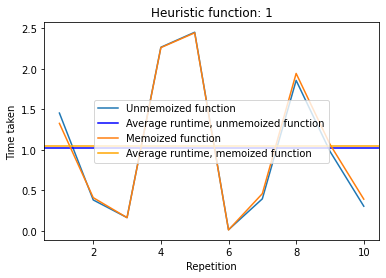

Heuristic function: 1
        Average runtime (unmemoized): 1.0278244495391846 seconds
        Average runtime (memoized): 1.048785185813904 seconds


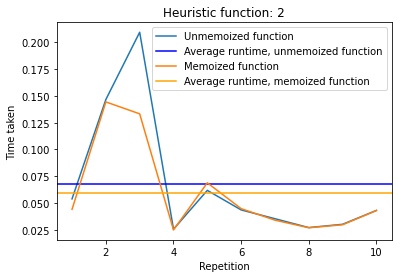

Heuristic function: 2
        Average runtime (unmemoized): 0.06766510009765625 seconds
        Average runtime (memoized): 0.05940067768096924 seconds


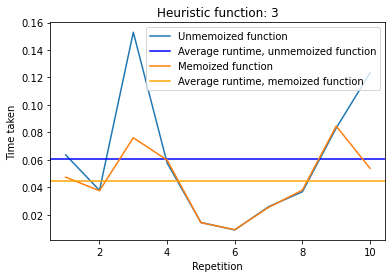

Heuristic function: 3
        Average runtime (unmemoized): 0.060403633117675784 seconds
        Average runtime (memoized): 0.04453608989715576 seconds


In [44]:
## Testing memoization
import random
import time 
import matplotlib.pyplot as plt

#Unmemoized heuristic functions vs memoized functions
unmemoized = [h1, h2, h3]
memoized = [h1_memoize, h2_memoize, h3_memoize]

def plot_memoization(unmemoized, memoized, reps = 10, n = 3, seed = 20):
    """
    This function plots how fast does memoized vs unmemoized function runs

    Parameters
    ----------
    unmemoized: list[func]
        The list of unmemoized functions
    memoized: list[func]
        The list of memoized functions
    reps: int
        The number of repetitions, default = 500
    n: int
        The size of the board, default = 4
    seed: int
        The seed for random function, default = 20

    Returns
    ----------
    None

    """
    random.seed(seed)
    #loop for each heuristic function pairs
    for func_idx in range(len(memoized)):
        unmemoized_func = unmemoized[func_idx]
        memoized_func = memoized[func_idx]

        #initialize storage
        unmemoized_storage = []
        memoized_storage = []

        #repeat the experiment reps times
        for _ in range(reps):
            # state = [[1,2,6,3],[0,9,5,7],[4,13,10,11],[8,12,14,15]]

            #I first tried this but it took too long to run
            state = []
            #create a random board that is solvable
            while (not state) or (not PuzzleNode(state, 0, 0, 0).is_solvable()):
                values = [i for i in range(n ** 2)]
                random.shuffle(values)
                state = []
                for i in range(n):
                    for j in range(n):
                        if j == 0:
                            state.append([])
                        state[-1].append(values[i * n + j])


            #time the unmemoized function
            start = time.time()
            unmemoized_steps, _, _, _, _ = solvePuzzle(state, memoized_func)
            end = time.time()
            unmemoized_storage.append(end - start)

            #time the memoized function
            start = time.time()
            memoized_steps, _, _, _, _ = solvePuzzle(state, memoized_func)
            end = time.time()
            memoized_storage.append(end - start)

            #assert they have the same results
            assert unmemoized_steps == memoized_steps

        x_vals = [i + 1 for i in range(reps)]
        average_unmemoized = sum(unmemoized_storage)/reps
        average_memoized = sum(memoized_storage)/reps
        #plot the pair functions
        plt.figure()
        plt.plot(x_vals, unmemoized_storage, label="Unmemoized function")
        plt.axhline(average_unmemoized, label="Average runtime, unmemoized function", color="blue")
        plt.plot(x_vals, memoized_storage, label="Memoized function")
        plt.axhline(average_memoized, label="Average runtime, memoized function", color="orange")
        plt.title(f"Heuristic function: {func_idx + 1}")
        plt.legend()
        plt.xlabel("Repetition")
        plt.ylabel("Time taken")
        plt.show()
        print(f"""Heuristic function: {func_idx + 1}
        Average runtime (unmemoized): {average_unmemoized} seconds
        Average runtime (memoized): {average_memoized} seconds""")

plot_memoization(unmemoized, memoized)

            
        


<h1>Extension Tests</h1>
The cells below can be used to test the extension questions.  Memoization if implemented will be tested on the final submission - you can test it yourself by testing the execution time of the heuristic functions with and without it.

In [ ]:
## Puzzle solvability test

unsolvable_initial_state = [[7,5,6],[2,4,3],[8,1,0]]
_,_,_,_,err = solvePuzzle(unsolvable_initial_state, lambda state: 0)
assert(err == -2)

In [ ]:
## Extra heuristic function test.  
## This tests that for all initial conditions, the new heuristic dominates over the manhattan distance.

dom = 0
for i in range(0,3):
    steps_new, expansions_new, _, _, _ = solvePuzzle(working_initial_states_8_puzzle[i], heuristics[2])
    steps_man, expansions_man, _, _, _ = solvePuzzle(working_initial_states_8_puzzle[i], heuristics[1])
    # Test whether the number of optimal steps is correct and the same
    assert(steps_new == steps_man == astar_steps[i])
    # Test whether or not the manhattan distance is dominated by the new heuristic in every case, by checking
    # the number of nodes expanded
    dom = expansions_man - expansions_new
    print(dom)
    assert(dom > 0)

In [ ]:
## Memoization test - will be carried out after submission